<h1><center>DALLAS CRIME DATA</center></h1>
<h2><center>MSDS 7331 LAB 2</center></h2>
<h2><center>Classification Modelling</center></h2>

<h4><center>Team Members</center></h4>

           Yejur Singh Kunwar           Bin Yu               Vivek Viswanathan          Kevin Mendonsa
              Dallas, TX               Dallas, TX               Dallas, TX                Irvine, CA

## Introduction
##### Data Description
The Dallas Crime Incident data set that is used in the Lab 2 acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 

For purposes of this analysis, the main dataframe has trimmed based on the analysis performed as part of Lab 1. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 notebook link provided below.

**Lab 1 Notebook Link -** https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb

The data set currently has 200,780 rows and 50 columns.

**Note -** The structure of the document will closely follow the phases of the CRISP-DM Modeling Phase.

##### Objective

The objective of this unit is to perform Predictive Analysis (Classification) on the chosen data set and apply new classification algorithms. The first task of this lab is to clasify the arrest made in the incident call based on the selected features in the dataset. The second task will attempt to categorize the response time (speed of dispatch) into the categories that have been defined below **(Provide Section Name)**.

**GitHub Repository containing the artifacts -** https://github.com/wtubin/MSDS7331-Data-Mining

**Location of the raw (compressed) data file -** https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

As part of this analysis, we are attempting to train and test our classification models using the **Stratified Shuffle Split** technique. The details of the Stratified Shuffle Split are discussed in the subsequent sections.

### Modeling Assumptions
For purposes of our classification, we have performed the following transformations to ensure:
 * All features are uniformly distributed with 0 mean and unit variance
 * Features are resampled to ensure that the response variables are balanced
 * Multi-collinearity has been addressed
 * Features have been converted to categories, where applicable, to improve model efficiency.

# Data Preparation Part 1

### Data Preparation

The dataset is loaded into the workspace as a data frame and undergoes transformation or standardization before being used into model. The attributes that do not contribute adequately in predicting the response variable have been excluded.  

Going forward, we will refer to the Explanatory variables as Features.

The dataset is split into explanatory, for running the models.

- TASK 1
    - inci_X : Explanatory variables (Features)
    - inci_Y : Response variable (Arrest_status)
        
- TASK 2
    - inci_res_X : Explanatory variables (Features)
    - inci_res_Y : Response variable (Response_time_cat)

The Features have been scaled to a mean of 0 and variance of 1 to improve accuracy of the classification models. The data will be split into 80/20 train-test set. Grid search technique was used to test the models with different parameters to identify the optimal values for each parameter. 

Correlation scores, variance inflation factors (VIFs) and feature significance have been leveraged for dimensionality reduction. The remaining features will be utilized in our models: KNN, Nearest Centroid and Support Vector Machine (SVM).

The following techniques have been used during the analysis to improve the performance and accuracy.
 - Class balancing using down sampling
 - Multi-collinearity was identified and addressed using  
     - Correlation Matrix
     - VIF
 - Scaling the features
 - Cross Validation was implemented using the following techniques 
     - Shuffle Split
     - Stratified Shuffle Split
     - Stratified K Split
 
A brief description of the purpose and outcome of each of the techniques is explained as they are being applied to the data set.

In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import plotly.tools as tls
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

In [165]:
# Importing data from Lab#1 and exploring the data, the csv file is the result dataset from Lab1
path = '../Data/'# Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean_new.csv', low_memory= False)

#### Data Clean up, standardization, and categorical feature creation

In [166]:
# Exploring the dataset
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)

# 0-11 (Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)
incident['Res_time_category'] = pd.cut(incident.Response_time,[0,11,31,60,1e6],2,labels=[0,1,2,3])
incident = incident[incident['Res_time_category'].isnull()==False]
incident = incident[incident['Call_Received_Hour'].isnull()==False]

# Further cleanup the dataset
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]

# Further data clean up of feature variables
incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

# Setup the UCR Offense Name Groups
THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    
# Regroup the UCR_Offense_Name
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

# Change nominal attributes to numeric
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)
incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']
incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

# Coding
incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes
# Added UCR_Offense_Description
incident['UCR_Offense_Description'] = pd.Categorical(incident['UCR_Offense_Description']).codes
incident['Res_time_category'] = pd.Categorical(incident['Res_time_category']).codes

In [167]:
# Print out the data properties
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

(200780, 50)
Number of null columns and their counts
Type_Location                3545
Reporting_Area                122
Beat                           51
Sector                         51
Call_Cleared_Date_Time        134
Call_Dispatch_Date_Time        18
Offense_Status                363
Victim_Condition           183709
Family_Offense                 27
Weapon_Used                 21303
UCR_Code                    11065
X_Coordinate                15809
Y_Coordinate                15809
State                         480
Call_Cleared                  134
Call_Dispatch                  18
Latitude                     7716
Longitude                    7716
dtype: int64


In [168]:
def get_unixtime(time):    
    return (time.astype(np.int64)/1e6).astype(np.int64)

import time
incident['Call_Received_Date_Time'] = pd.to_datetime(incident['Call_Received_Date_Time'])
incident['Call_Cleared_Date_Time'] = pd.to_datetime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time'] = pd.to_datetime(incident['Call_Dispatch_Date_Time'])

incident['Call_Received_Date_Time_epoch']= get_unixtime(incident['Call_Received_Date_Time'])
incident['Call_Cleared_Date_Time_epoch']=get_unixtime(incident['Call_Cleared_Date_Time'])
incident['Call_Dispatch_Date_Time_epoch']=get_unixtime(incident['Call_Dispatch_Date_Time'])

In [169]:
# Drop columns that do not contribute towards our model
incident = incident.drop(['Incident_Number_w/year','Year_of_Incident', 'Service_Number_ID', 'Type_of_Incident','Type_Location', 
                          'Reporting_Area', 'Beat', 'Sector','Council_District','Call_Received_Date_Time',
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 
                          'Victim_Gender', 'Offense_Status', 'Victim_Condition','Family_Offense', 'Weapon_Used', 
                          'RMS_Code', 'UCR_Code', 'Zip_Code', 'City', 'State',
                          'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch','Latitude', 'Longitude','Unnamed: 0'
                          #,'X_Coordinate', 'Y_Coordinate'
                         #,'Call_Received_Date_Time_epoch', 'Call_Cleared_Date_Time_epoch','Call_Dispatch_Date_Time_epoch'
                         ],axis=1)

incident= incident.dropna()

In [170]:
incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184971 entries, 0 to 255153
Data columns (total 23 columns):
Watch                            184971 non-null int64
Division                         184971 non-null int8
Day1_of_the_Week                 184971 non-null int8
Victim_Type                      184971 non-null int8
Victim_Race                      184971 non-null int8
Victim_Age                       184971 non-null int32
Hate_Crime                       184971 non-null int64
Gang_Related_Offense             184971 non-null int64
Drug_Related                     184971 non-null int64
UCR_Offense_Name                 184971 non-null int8
X_Coordinate                     184971 non-null float64
Y_Coordinate                     184971 non-null float64
UCR_Offense_Description          184971 non-null int8
Number_of_offense                184971 non-null int32
Response_time                    184971 non-null int32
Arrest_status                    184971 non-null int64
Call_Receiv

### Response Variable Analysis

As part of this analysis, we look at the distinct values and distribution of the response variable. 

- Arrest status
    - 0 = Arrest not made
    - 1 = Arrest made

- Response time category
    - 0 = Non Urgent (61-Max Minutes)
    - 1 = Important (32-60 Minutes)
    - 2 = Urgent (12-31 Minutes)
    - 3 = Emergency (0-11 Minutes)

# 0-11 (Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)

Class 0: 166451
Class 1: 18520


<Figure size 576x360 with 0 Axes>

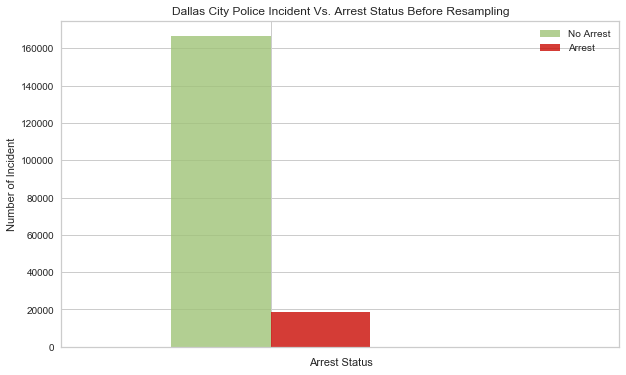

In [171]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Draw bar plot

# data to plot
n_groups = 1
NoArrest=incident.Arrest_status.value_counts()[0]
Arrest=incident.Arrest_status.value_counts()[1]
 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, NoArrest, bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Arrest')
 
plt.bar(index + bar_width, Arrest, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

Class 0: 94192
Class 1: 44893
Class 2: 27847
Class 3: 18039


<Figure size 576x360 with 0 Axes>

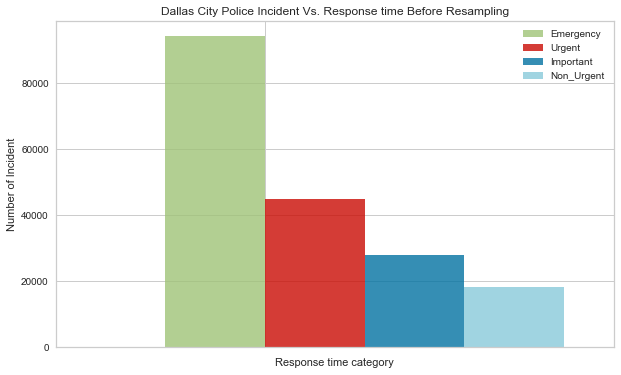

In [172]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = incident.Res_time_category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])

# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# print('Proportion1:', round(target_count[0] / target_count[2], 2), ': 1')
# print('Proportion2:', round(target_count[0] / target_count[3], 2), ': 1')

# (0-11)(Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)


# data to plot
n_groups = 1
Emergent=incident.Res_time_category.value_counts()[0]
Urgent=incident.Res_time_category.value_counts()[1]
Important=incident.Res_time_category.value_counts()[2]
Non_Urgent=incident.Res_time_category.value_counts()[3] 
# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, Emergent, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Emergency')
 
plt.bar(index + bar_width, Urgent, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Urgent')
 
plt.bar(index + bar_width+ 0.5, Important, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Important')

plt.bar(index + bar_width+ 1.0 , Non_Urgent, bar_width,
                 alpha=opacity,
                 color='c',
                 label='Non_Urgent')

plt.xlabel('Response time category')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Response time Before Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()
incident_response_time_cat = incident.copy()

### Resampling (Downsampling) the data set

Based on the above analysis, we have an unbalanced proportion of samples arrests made versus to arrests not made. 

In an unbalanced class, we cannot reliably use accuracy to measure performance. This makes training the model very tricky. The model may predict the majority class better and sometimes ignore the minority class completely. There are 2 ways to balance the data set: downsampling and upsampling. We selected the downsampling as we have a sufficiently large dataset.

We performed down-sampling by 
1. Separating observations based on class
2. Resample the majority class without replacement after setting the number of samples to match the minority class count
3. Concatenated the down-sampled majority class with the original minority class

We plotted the distribution of the response variable classes to ensure that it is balanced before proceeding with further analysis.

Source: https://elitedatascience.com/imbalanced-classes

In [173]:
# Import resample package
from sklearn.utils import resample

# Downsampling
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=18520,  # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()

1    18520
0    18520
Name: Arrest_status, dtype: int64

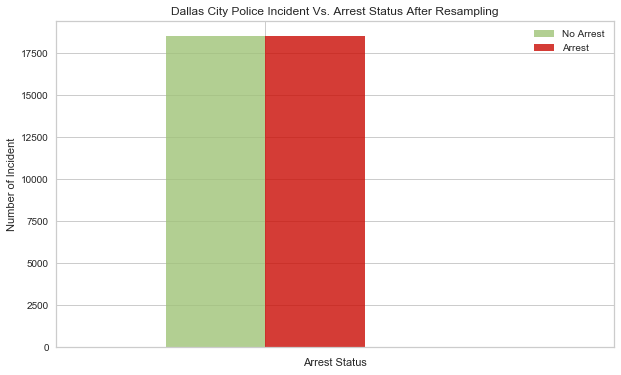

In [174]:
n_groups = 1
NoArrest=df_downsampled.Arrest_status.value_counts()[0]
Arrest=df_downsampled.Arrest_status.value_counts()[1]
 
# create plot
#ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, 
        NoArrest, 
        bar_width,
        alpha=opacity,
        color='g',
        label='No Arrest')
 
plt.bar(index + bar_width, 
        Arrest, 
        bar_width,
        alpha=opacity,
        color='r',
        label='Arrest')
 
plt.xlabel('Arrest Status')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Arrest Status After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
#plt.tight_layout()
plt.show()

In [175]:
# Downsampling
df_resp_cat_0 = incident_response_time_cat[incident_response_time_cat.Res_time_category==0]
df_resp_cat_1 = incident_response_time_cat[incident_response_time_cat.Res_time_category==1]
df_resp_cat_2 = incident_response_time_cat[incident_response_time_cat.Res_time_category==2]
df_resp_cat_3 = incident_response_time_cat[incident_response_time_cat.Res_time_category==3]
 
# Downsample majority class
df_resp_downsampled_0 = resample(df_resp_cat_0, 
                                 replace=False,    # sample without replacement
                                 n_samples=18039,  # to match minority class
                                 random_state=123) # reproducible results
 
df_resp_downsampled_1 = resample(df_resp_cat_1, 
                                 replace=False,    # sample without replacement
                                 n_samples=18039,  # to match minority class
                                 random_state=123) # reproducible results
 
df_resp_downsampled_2 = resample(df_resp_cat_2, 
                                 replace=False,    # sample without replacement
                                 n_samples=18039,  # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_resp_downsampled = pd.concat([df_resp_downsampled_0, df_resp_downsampled_1, df_resp_downsampled_2, df_resp_cat_3])
 
# Display new class counts
df_resp_downsampled.Res_time_category.value_counts()

3    18039
2    18039
1    18039
0    18039
Name: Res_time_category, dtype: int64

Class 0: 18039
Class 1: 18039
Class 2: 18039
Class 3: 18039


<Figure size 576x360 with 0 Axes>

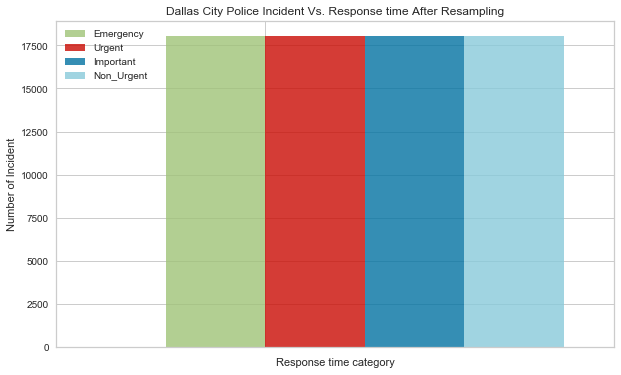

In [176]:
# Explore response variable distribution
plt.figure(figsize=(8,5))
target_count = df_resp_downsampled.Res_time_category.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])

# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# print('Proportion1:', round(target_count[0] / target_count[2], 2), ': 1')
# print('Proportion2:', round(target_count[0] / target_count[3], 2), ': 1')

# (0-11)(Emergency), 11-31(Urgent), 31-60(Important), (60-max)(Non_Urgent)


# data to plot
n_groups = 1
Emergent=df_resp_downsampled.Res_time_category.value_counts()[0]
Urgent=df_resp_downsampled.Res_time_category.value_counts()[1]
Important=df_resp_downsampled.Res_time_category.value_counts()[2]
Non_Urgent=df_resp_downsampled.Res_time_category.value_counts()[3] 

# create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, Emergent, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Emergency')
 
plt.bar(index + bar_width, Urgent, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Urgent')
 
plt.bar(index + bar_width+ 0.5, Important, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Important')

plt.bar(index + bar_width+ 1.0 , Non_Urgent, bar_width,
                 alpha=opacity,
                 color='c',
                 label='Non_Urgent')

plt.xlabel('Response time category')
plt.ylabel('Number of Incident')
plt.title('Dallas City Police Incident Vs. Response time After Resampling')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [177]:
# copy the down sampled dataset to the original incident data frame and continue the analysis
incident= df_downsampled.copy()
incident_resp = df_resp_downsampled.copy()

### Collinearity

As part of Lab 1 data exploration, we identified that some attributes in the original dataset appeared to be highly collinear. In other words, one predictor variable in the regression model can be linearly predicted from the others with a substantial degree of accuracy.

During this exercise, additional collinearity was introduced because:
 * Continuous Variables were converted to Categorical variables (e.g. Response Time & Victim Age were converted to Categorical)
 * Derived Features based on (or a combination of) values of existing features (e.g. Social Crime Score)
 * Identical features where one was a roll up of the other (e.g. Watch & Call Received Hour)
 
Based on the analysis of the Correlation Matrix, we dropped one or more features from the pairs that were highly correlated.

In [178]:
# Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)

# REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Res_time_category        Response_time              0.955328
Drug_Related             Social_crime_score         0.841239
Watch                    Call_Received_Hour         0.732130
UCR_Offense_Description  UCR_Offense_Name           0.690865
Social_crime_score       Gang_Related_Offense       0.565914
                                                      ...   
Arrest_status            Response_time             -0.179920
                         UCR_Offense_Description   -0.244570
Victim_Race              Division                  -0.285132
Arrest_status            UCR_Offense_Name          -0.311077
Division                 Y_Coordinate              -0.632288
Length: 253, dtype: float64


# Data Preparation Part 2

In [179]:
incident.describe()

Watch      Division  Day1_of_the_Week   Victim_Type  \
count  37040.000000  37040.000000      37040.000000  37040.000000   
mean       2.068359      3.207775          2.946841      2.000000   
std        0.822300      1.980063          1.988997      0.016431   
min        1.000000      0.000000          0.000000      1.000000   
25%        1.000000      2.000000          1.000000      2.000000   
50%        2.000000      3.000000          3.000000      2.000000   
75%        3.000000      5.000000          5.000000      2.000000   
max        3.000000      7.000000          6.000000      3.000000   

        Victim_Race    Victim_Age    Hate_Crime  Gang_Related_Offense  \
count  37040.000000  37040.000000  37040.000000          37040.000000   
mean       3.355886     38.370680      0.000459              0.005643   
std        1.632117     14.236969      0.021419              0.074906   
min        0.000000      0.000000      0.000000              0.000000   
25%        2.000000     27.000000      0.000000              0.000000   
50%        3.000000     35.000000      0.000000              0.000000   
75%        6.000000     48.000000      0.000000              0.000000   
max        6.000000     89.000000      1.000000              1.000000   

       Drug_Related  UCR_Offense_Name              ...                \
count  37040.000000      37040.000000              ...                 
mean       0.013850          2.541172              ...                 
std        0.116869          2.239604              ...                 
min        0.000000          0.000000              ...                 
25%        0.000000          0.000000              ...                 
50%        0.000000          3.000000              ...                 
75%        0.000000          5.000000              ...                 
max        1.000000          6.000000              ...                 

       Number_of_offense  Response_time  Arrest_status  Call_Received_Hour  \
count       37040.000000   37040.000000   37040.000000        37040.000000   
mean            1.125702      18.298974       0.500000           12.839606   
std             0.549323      22.031901       0.500007            6.505660   
min             1.000000       1.000000       0.000000            0.000000   
25%             1.000000       3.000000       0.000000            8.000000   
50%             1.000000       8.000000       0.500000           13.000000   
75%             1.000000      25.000000       1.000000           18.000000   
max            22.000000      97.000000       1.000000           23.000000   

       Res_time_category        IsMale  Social_crime_score  \
count       37040.000000  37040.000000        37040.000000   
mean            0.703024      0.530211            0.019951   
std             0.958116      0.499093            0.143833   
min             0.000000      0.000000            0.000000   
25%             0.000000      0.000000            0.000000   
50%             0.000000      1.000000            0.000000   
75%             1.000000      1.000000            0.000000   
max             3.000000      1.000000            2.000000   

       Call_Received_Date_Time_epoch  Call_Cleared_Date_Time_epoch  \
count                   3.704000e+04                  3.704000e+04   
mean                    1.464157e+12                  1.457539e+12   
std                     3.614800e+10                  2.686831e+11   
min                     1.401572e+12                 -9.223372e+12   
25%                     1.433790e+12                  1.433767e+12   
50%                     1.462973e+12                  1.462954e+12   
75%                     1.493808e+12                  1.493803e+12   
max                     1.536308e+12                  1.536317e+12   

       Call_Dispatch_Date_Time_epoch  
count                   3.704000e+04  
mean                    1.463006e+12  
std                     1.167932e+11  
min                    -9.223372e+12

**Features from Original data set:**

<p align="left">Attribute</p>|<p align="left">Data Type</p>|<p align="left">Description</p> 
:--------- | :----------------- | :-------------               | :---------
<p align="left">Watch</p>|Norminal|<p align="left">Police watch 1st 2nd or 3rd (1st watch = Late Night, 2nd watch = Days and 3rd watch = Evenings)</p>
<p align="left">Division</p>|Norminal|<p align="left">Geographic area comprised of census blocks where incident occurred </p>
<p align="left">Day1_of_the_Week</p>|Interval|<p align="left">Day of the indent based on the Date of Occurrence (Date1). Internal use</p>
<p align="left">Victim_Type</p>|Norminal|<p align="left">Victim Type</p>
<p align="left">Victim_Race</p>|Norminal|<p align="left">Victim Race</p>
<p align="left">Victim_Age</p>|Ratio|<p align="left">Victim Age</p>
<p align="left">Hate_Crime</p>|Interval|<p align="left">Yes or no if offense is a hate crime. We keep this attribute as we may find useful information in it</p>
<p align="left">Gang_Related_Offense</p>|Interval|<p align="left">Yes or no if offense is gang realated</p>
<p align="left">Drug_Related_Incident</p>|Interval|<p align="left">Yes or no if incident is drug related</p>
<p align="left">UCR_Offense_Name</p>|Norminal|<p align="left">UCR Offense Name</p>
<p align="left">X_Coordinate</p>|Interval|<p align="left">X Coordinate</p>
<p align="left">Y_Coordinate</p>|Norminal|<p align="left">Y Coordinate</p>
<p align="left">UCR_Offense_Description</p>|Norminal|<p align="left">UCR Offense Description</p>

#### Features Created by transforming existing features:

<p align="left">Attribute</p>|<p align="left">Data Type</p>|<p align="left">Description</p>  
:--------- | :----------------- | :-------------               
<p align="left">Number_of_offense</p>|Interval|<p align="left">Number of Offense, calculated attribute</p>
<p align="left">Response_time</p>|Interval|<p align="left">Response time, calculated attribute used for **task 2**.</p>
<p align="left">Arrest_status</p>|Interval|<p align="left">Arrest or No Arrest, calculated attribute used for **task 1**.</p>
<p align="left">Call_Received_Hour</p>|Interval|<p align="left">Call Received Hours, calculated attribute</p>
<p align="left">IsMale</p>|Interval|<p align="left">Is Male or Not, calculate from the Victim Gender, calculated attribute</p>
<p align="left">Social_crime_score</p>|Interval|<p align="left">Social crime score, calculated attribute from Gang_Related_Offense, Drug_Related_Incident</p>
<p align="left">Call_Received_Date_Time_epoch</p>|Interval|<p align="left">Call Received Time with numeric format, calculated attribute</p>
<p align="left">Call_Cleared_Date_Time_epoch</p>|Interval|<p align="left">Call Cleared Time with numeric format, calculated attribute</p>
<p align="left">Call_Dispatch_Date_Time_epoch</p>|Interval|<p align="left">Call Dispatch Time with numeric format, calculated attribute</p>
<p align="left">Res_time_category</p>|Interval|<p align="left">Response Time Category, calculated attribute</p>


# Modeling and Evaluation 1

The performance of the Classification models were measured using the following evaluation metrics:

 - Accuracy: **True positive + True negative / (True positive + False positive + True negative + False negative)**. It is the percentage of correct predictions.
 
 - Precision: **True positive / (True positive + False positive)**. It is a measurement of relevance of the analysis. It means that an algorithm returned substantially more relevant results than irrelevant ones.
 
 - Recall: **True positive / (True positive + False negative)**. It is a measurement of completeness of the analysis. It means that an algorithm returned most of the relevant results. 
 
 - F1 score: Is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively, it is not as easy to understand as accuracy, but F1 score is usually more useful than accuracy, especially with an uneven class distribution.
 
 - AUC & ROC: Area Under the Curve (AUC) is used in classification analysis in order to determine which of the models predicts the classes best. An example of its application are Receiver Oprating Characterstic (ROC) curves. Here, the true positive rates are plotted against false positive rates.

The metrics above provide the best measures to evaluate the models as they deliver a consistent scale on which models can be compared to each other. These types of metrics are scalar in nature where the entire model performance can be presented using a single score value. Thus, making it easier to do the comparison and analysis, although it could mask subtle details of their behaviours. Classification accuracy is the easiest classification metric to understand, but it does not tell you the underlying distribution of response values. It also does not tell you what "types" of errors the classifier is making. 

Since we are classifying the arrest status for Task 1, we would prefer to Optimize for sensitivity and hence target better Recall. 
As part of Task 2, we are classifying the Response Time Category, and therefore improve Accuracy, Recall and Precision.

# Modeling and Evaluation 2 

## Cross Validation techniques 
### Shuffle Split
The **Shuffle Split** technique is a random permutation cross-validator. It returns the indices to split data into training and test sets.
### Stratified K Split
In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels.
### Stratified Shuffle Split
The **Stratified Shuffle Split** cross validation iterator was chosen for dividing the data into training and testing data sets.  It provides train/test indices to split data into the train and test sets. This cross-validation method is a merge of the StratifiedKFold and ShuffleSplit iterators, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

The **difference between** StratifiedKFold and StratifiedShuffleSplit is that StratifiedKFold just shuffles and splits once, therefore the test sets do not overlap, while StratifiedShuffleSplit shuffles each time before splitting, and it splits n_splits times, therefore the resulting test sets can overlap.

# Modeling and Evaluation 3 

- Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

### k-NN
In KNN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method (it does not make any assumptions on the underlying data distribution) used for classification. The input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression. It is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g. distance functions).

##### Limitations of k-NN
- In high dimensions, points that may be similar may have very large distances. All points will be far away from each other and our intuition for distances in simple 2 and 3-dimensional spaces breaks down. This might feel unintuitive at first, but this general problem is called the “Curse of Dimensionality“.

- Each input variable can be considered a dimension of a p-dimensional input space. For example, if you had two input variables x1 and x2, the input space would be 2-dimensional.

- As the number of dimensions increases the volume of the input space increases at an exponential rate.

##### Prepping for k-NN
- Rescale Data: KNN performs much better if all of the data has the same scale. Normalizing your data to the range [0, 1] is a good idea. It may also be a good idea to standardize your data if it has a Gaussian distribution.

- Address Missing Data: Missing data will mean that the distance between samples can not be calculated. These samples could be excluded or the missing values could be imputed.

- Lower Dimensionality: KNN is suited for lower dimensional data. You can try it on high dimensional data (hundreds or thousands of input variables) but be aware that it may not perform as well as other techniques. KNN can benefit from feature selection that reduces the dimensionality of the input feature space.

### RANDOM FORESTS
Source: https://www.datascience.com/resources/notebooks/random-forest-intro

Random forests, also known as random decision forests, are a popular ensemble method to build predictive models for both classification and regression. The ensemble methods uses multiple learning models to gain better predictive results — in the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.

Decision trees are simple but intuitive models that utilize a top-down approach in which the root node creates binary splits until a certain criteria is met. This binary splitting of nodes provides a predicted value based on the interior nodes leading to the terminal (final) nodes. In a classification context, a decision tree will output a predicted target class for each terminal node produced.

Source: www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings
##### Features of Random Forests
- Unexcelled in accuracy among current algorithms.
- Runs efficiently on large data bases.
- Can handle thousands of input variables without variable deletion.
- Provides estimates of what variables are important in the classification.
- Generates an internal unbiased estimate of the generalization error as the forest building progresses.
- Effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
- Includes methods for balancing error in class population unbalanced data sets.
- Generated forests can be saved for future use on other data.
- Prototypes are computed that give information about the relation between the variables and the classification.
- Computes proximities between pairs of cases that can be used in clustering, locating outliers, or (by scaling) give interesting views of the data.
- Capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.
- Offers an experimental method for detecting variable interactions.

##### Limitations to Decision Trees
Decision trees tend to have high variance when they utilize different training and test sets of the same data, since they tend to overfit on training data. This leads to poor performance on unseen data. Unfortunately, this limits the usage of decision trees in predictive modeling. However, using ensemble methods, we can create models that utilize underlying decision trees as a foundation for producing powerful results.


### SVM
##### Interpreting Support Vectors (from mini lab)

For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimensional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can examine individual features to investigate how SVM approaches classification problems.In the case below, we are vizualizing decision boundaries of two features i.e UCR_Offense_Name and Division.

- In this section, the models for classification of two task where Arrest Status and Response Time Category will be build.
- Models per task = 3 
- These are two predictive tasks spanning two different modes of machine learning. 
- Both prediction as a classification task.
- The available features will be utilized for classiffication of Arrest status. 

- MAYBE BASE LINE AS LOGIT

The cross validation will be performed for each task as mentioned........***

### TASK 1
- Arrest Status Classification

In [ ]:
incident.info()

In [180]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']
# Features with no predictive features with respect to resposne variable 
# Also dropping highly correlated attributes
inci_X = incident.drop(['Arrest_status', 'Res_time_category', 'Drug_Related', 'Watch'],axis=1)

from sklearn.preprocessing import StandardScaler
#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)

In [181]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors before Scaling")
df2_vif

VIF Factors before Scaling


VIF Factor                       features
0     1.186797                       Division
1     1.001998               Day1_of_the_Week
2     0.876084                    Victim_Type
3     1.131458                    Victim_Race
4     1.023716                     Victim_Age
5     1.033949                     Hate_Crime
6     1.492941           Gang_Related_Offense
7     1.949590               UCR_Offense_Name
8     0.871385                   X_Coordinate
9     0.426452                   Y_Coordinate
10    1.946944        UCR_Offense_Description
11    1.022973              Number_of_offense
12    1.027414                  Response_time
13    1.014279             Call_Received_Hour
14    1.018442                         IsMale
15    1.544325             Social_crime_score
16    1.122728  Call_Received_Date_Time_epoch
17    1.020392   Call_Cleared_Date_Time_epoch
18    1.109430  Call_Dispatch_Date_Time_epoch

In [182]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = df_inci_X_scaled.columns
print("VIF Factors after Scaling")
df2_vif

VIF Factors after Scaling


VIF Factor  features
0     1.761594         0
1     1.002003         1
2     1.000429         2
3     1.135227         3
4     1.024055         4
5     1.033955         5
6     1.493084         6
7     1.953529         7
8     1.030180         8
9     1.695376         9
10    1.948962        10
11    1.023071        11
12    1.027451        12
13    1.014319        13
14    1.018502        14
15    1.544358        15
16    1.143185        16
17    1.020425        17
18    1.109431        18

##### Baseline model

In [183]:
# LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL
from sklearn import metrics as mt
import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, inci_X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.622140
         Iterations 6
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.102     
Dependent Variable:      Arrest_status        AIC:                  46100.1462
Date:                    2018-10-26 09:01     BIC:                  46151.2647
No. Observations:        37040                Log-Likelihood:       -23044.   
Df Model:                5                    LL-Null:              -25674.   
Df Residuals:            37034                LLR p-value:          0.0000    
Converged:               1.0000               Scale:                1.0000    
No. Iterations:          6.0000                                               
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------


###### Cross Validation

For the below model execution, we use Cross Validation to improve the model classification. We use the below settings for the cross validation module.

    1. The data is divided into 80/20 train -test split.
    2. 10 folds cross validation
    3. Random seed with random state 0 for random test and training splits for each iteration of cross validation

### TASK 1.1
###### KNN Classification 

- Parameter Optimization

K-Nearest Neighbor (KNN) classification is valid option for this dataset since the dataset has been preprocessed and it has no missing values. Parameter selections are critical to the performance of KNN classifiers; therefore, substantial time and effort was put forth to fully investigate the optimal parameters.

#### Parameter Settings


**Writeup

###### KNN Classification Parameter Optimization with GridSearch

In [184]:
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [110]:
#KNN Classification 10-fold cross-validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
import warnings
warnings.filterwarnings('ignore')

ClsEstimator = KNeighborsClassifier()#(n_jobs = -1)

parameters = { 'n_neighbors':[3, 5, 13]
              ,'weights': ['uniform','distance']
              ,'leaf_size': [10, 30]
              ,'metric': ['minkowski','euclidean']
             }
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
ClsGridSearch = GridSearchCV(estimator=ClsEstimator
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
ClsGridSearch.fit(df_inci_X_scaled, inci_Y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  7.6min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 40.7min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 51.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [3, 5, 13], 'weights': ['uniform', 'distance'], 'leaf_size': [10, 30], 'metric': ['minkowski', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [111]:
#Use the best parameters for our KNN classifier
ClsGridSearchEst = ClsGridSearch.best_estimator_
print(ClsGridSearchEst)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='distance')


In [186]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support

yhat = np.zeros(y.shape) # initializing variable

X=inci_X.as_matrix().astype(np.float)
y=inci_Y.as_matrix().astype(np.float)
for train, test in cv.split(X,y):
    # Use Results parameters from GridSearch to run KNN Classifier model
    clf_knn = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                                   metric_params=None, n_jobs=1, n_neighbors=13, p=2,weights='distance')
    clf_knn.fit(X[train],y[train])
    yhat[test] = clf_knn.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
total_precision = precision_score(y, yhat)
classification_rpt = classification_report(y, yhat)
print ("KNN accuracy with corresponding parameter settings")
print('KNN classifier accuracy with optimal parameters is: %.3f'%(total_accuracy))
print('KNN classifier precision with optimal parameters is: %.3f'%(total_precision))
print('KNN classifier classsification report with optimal parameters is: \n',(classification_rpt))

KNN accuracy with corresponding parameter settings
KNN classifier accuracy with optimal parameters is: 0.568
KNN classifier precision with optimal parameters is: 0.579
KNN classifier classsification report with optimal parameters is: 
              precision    recall  f1-score   support

        0.0       0.56      0.63      0.60     18520
        1.0       0.58      0.50      0.54     18520

avg / total       0.57      0.57      0.57     37040



In [187]:
from sklearn import metrics as mt

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()


[0.63 0.5 ]


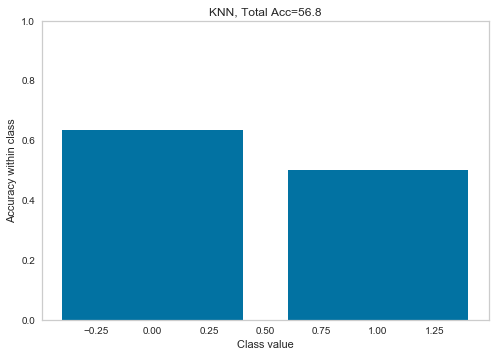

In [188]:
print(per_class_accuracy(y,yhat))
plot_class_acc(y,yhat,title="KNN")

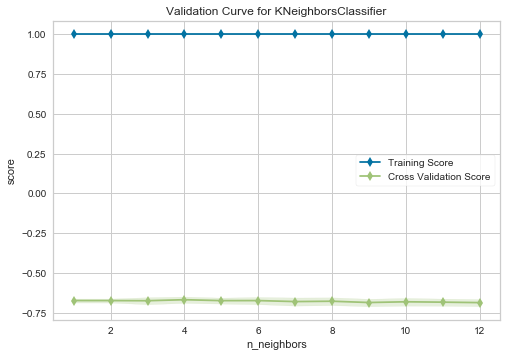

In [190]:
# Validation Curv
from yellowbrick.model_selection import ValidationCurve
from sklearn.neighbors import KNeighborsClassifier

param_range = np.arange(1, 13)

oz = ValidationCurve(
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                   metric_params=None, n_jobs=1, n_neighbors=13, p=2,weights='distance'), 
    param_name="n_neighbors",
    param_range=param_range, cv=cv, scoring="r2", n_jobs=4,
)

oz.fit(X,y)
oz.poof()


### TASK 1.2

#### RandomForest Classifier 

###### Main Random Forest Funtion

This function will be utilized by both the position classification and salary regression tasks. The function performs cross validation, scoring and feature importance.

In [191]:

# Random Forest
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

# Y Response variable dataframe
y = inci_Y
# Features with no predictive features with respect to resposne variable
X = inci_X

def runModelCV(cv, clf, varImp = True):
    imps = list()
    accList = list()
    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]  
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accList.append(acc)
        print("Model", i, "Accuracy:", acc)
        imps.append(clf.feature_importances_)
        i += 1
    
    print("Mean Accuracy Across Models: ",np.mean(np.asarray(accList)))
    
    if(varImp):
        fig, ax = plt.subplots(figsize=(15,10))
        im = ax.imshow(imps)
        ax.set_xticks(np.arange(X.shape[1]))
        ax.set_yticks(np.arange(i - 1))
        ax.set_xticklabels(list(X))
        ax.set_yticklabels(np.arange(i) + 1)
        ax.set_xlabel("Feature")
        ax.set_ylabel("Model")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        ax.set_title("Comparison of Variable Importance Across CV Runs")
        fig.tight_layout()
        plt.show()

The modeling steps below investigate different stratified cross validation methods, classifiers and classifer parameters to obtain the optimal accuracy scores.

MODEL TYPE: RandomForestClassifier with StratifiedShuffleSplit 
Model 1 Accuracy: 0.7455453563714903
Model 2 Accuracy: 0.7470302375809935
Model 3 Accuracy: 0.7432505399568035
Model 4 Accuracy: 0.7386609071274298
Model 5 Accuracy: 0.7417656587473002
Mean Accuracy Across Models:  0.7432505399568036


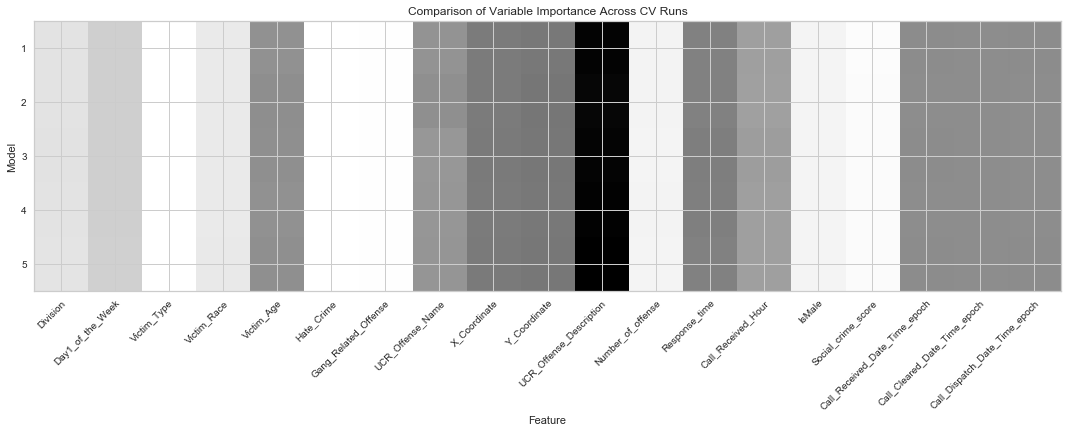

****************************************************************************************
MODEL TYPE: RandomForestClassifier with StratifiedKFold 
Model 1 Accuracy: 0.7446004319654428
Model 2 Accuracy: 0.7329913606911447
Model 3 Accuracy: 0.7431155507559395
Model 4 Accuracy: 0.7378509719222462
Model 5 Accuracy: 0.7055885529157667
Mean Accuracy Across Models:  0.7328293736501079


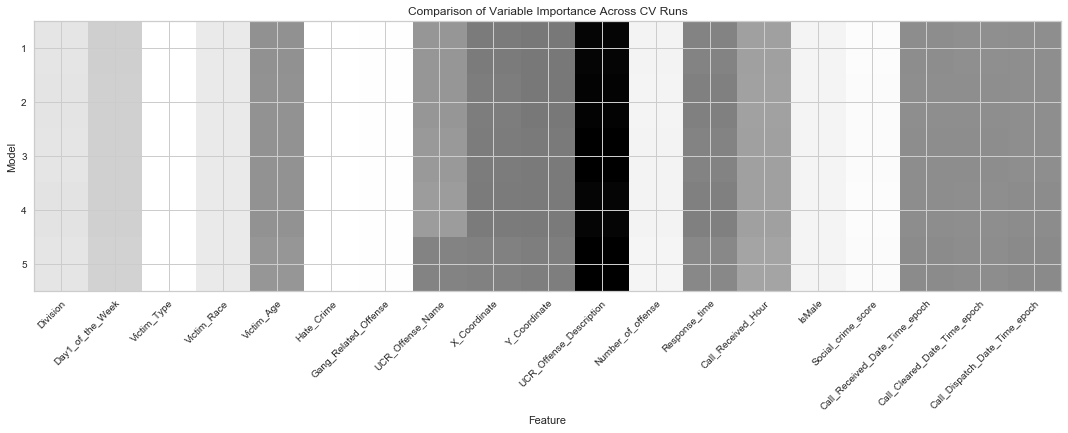

In [192]:
print("MODEL TYPE: RandomForestClassifier with StratifiedShuffleSplit ")
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, train_size=0.8, random_state=0),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))
print('****************************************************************************************')
print("MODEL TYPE: RandomForestClassifier with StratifiedKFold ")
runModelCV(StratifiedKFold(n_splits=5),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

MODEL TYPE: ExtraTreesClassifier with StratifiedShuffleSplit 
Model 1 Accuracy: 0.7398758099352052
Model 2 Accuracy: 0.7436555075593952
Model 3 Accuracy: 0.7435205183585313
Model 4 Accuracy: 0.7383909287257019
Model 5 Accuracy: 0.7428455723542117
Mean Accuracy Across Models:  0.7416576673866091


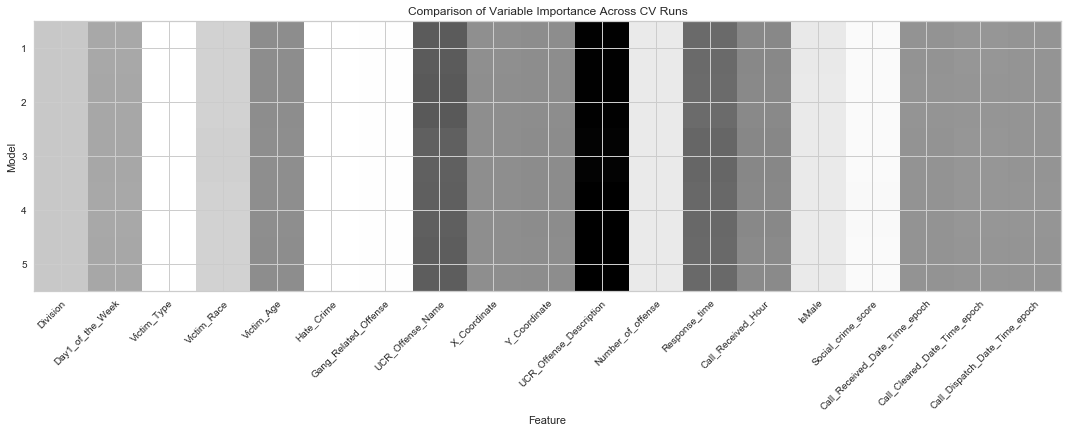

****************************************************************************************
MODEL TYPE: ExtraTreesClassifier with StratifiedKFold 
Model 1 Accuracy: 0.7433855291576674
Model 2 Accuracy: 0.7323164146868251
Model 3 Accuracy: 0.7397408207343412
Model 4 Accuracy: 0.7405507559395248
Model 5 Accuracy: 0.7023488120950324
Mean Accuracy Across Models:  0.7316684665226781


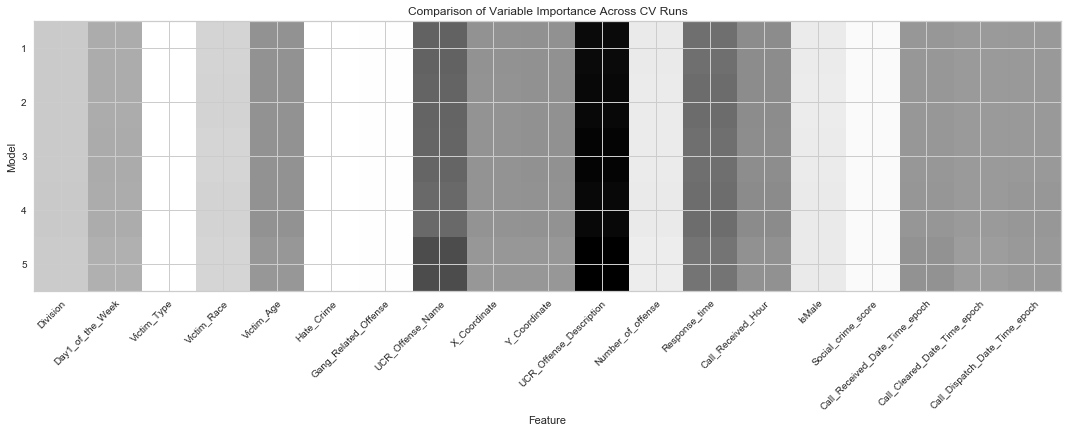

In [193]:
print("MODEL TYPE: ExtraTreesClassifier with StratifiedShuffleSplit ")
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, train_size=0.8, random_state=0),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))
print('****************************************************************************************')
print("MODEL TYPE: ExtraTreesClassifier with StratifiedKFold ")
runModelCV(StratifiedKFold(n_splits=5),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

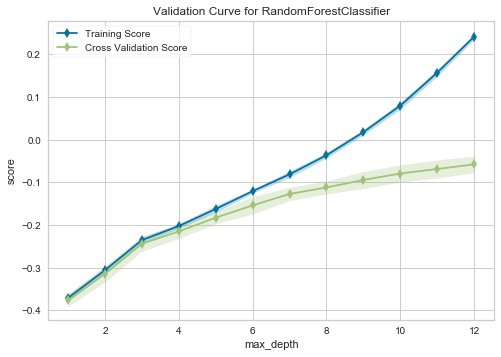

In [194]:
# Validation Curv
from yellowbrick.model_selection import ValidationCurve
from sklearn.ensemble import RandomForestClassifier

param_range = np.arange(1, 13)

oz = ValidationCurve(
    RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1), 
    param_name="max_depth",
    param_range=param_range, cv=cv, scoring="r2", n_jobs=4,
)


oz.fit(X,y)
oz.poof()

## TASK 1.3
### Logistic Regression with Recursive Feature Elimination (RFECV)

In [195]:
# Credit: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

In [196]:
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [197]:
%%time

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit


print("RFE CV Logistic Regression 1st Pass")
rfecvEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(df_inci_X_scaled, inci_Y)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv, scoring='accuracy', verbose=1)
X_BestFeatures = rfecv.fit_transform(df_inci_X_scaled, inci_Y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Logistic Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

#Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(df_inci_X_scaled, inci_Y)


RFE CV Logistic Regression 1st Pass
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


In [198]:
#Use the best parameters from RFE for our Logistic Regression object
EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_scaled, inci_Y, cv, 'Rfe')

The average accuracy for all cv folds is: 			 0.66254
The average precision for all cv folds is: 			 0.67755
The average recall for all cv folds is: 			 0.62334
*********************************************************
Cross Validation Fold Mean Error Scores


Accuracy  Precision    Recall
0  0.654698   0.672631  0.613922
1  0.665227   0.686205  0.620118
2  0.663337   0.674384  0.619242
3  0.666037   0.680491  0.628032
4  0.665632   0.676334  0.631465
5  0.664012   0.675755  0.625000
6  0.662527   0.670458  0.626601
7  0.663202   0.690058  0.621871
8  0.662527   0.668865  0.634312
9  0.658207   0.680284  0.612800

In [199]:
from matplotlib import pyplot as plt

def plotCoef(coef, names, t):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
    plt.figure(figsize=(9,12))
    barlist = plt.barh(range(len(names)), imp, align='center')
    for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
        barlist[x].set_color('r')
    plt.yticks(range(len(names)), names)
    plt.title(t)
    plt.show()

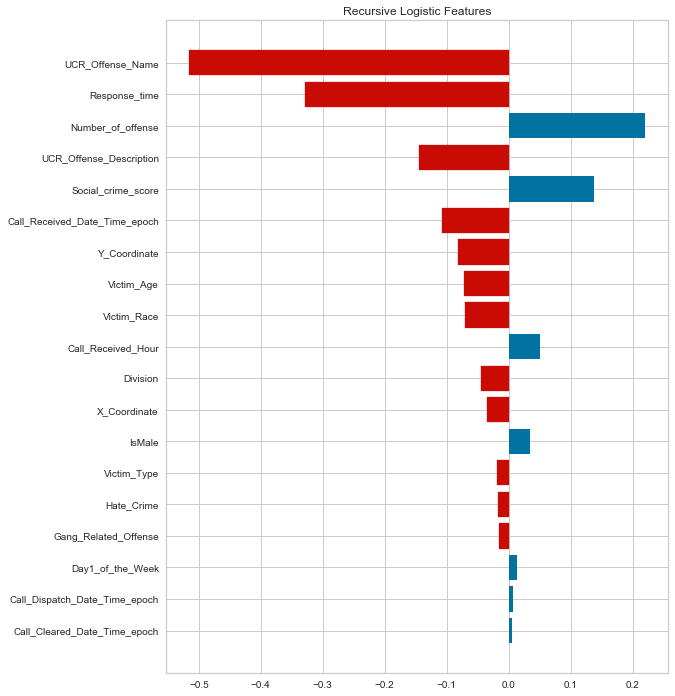

[(-0.5163145703993268, 'UCR_Offense_Name'),
 (-0.32866552797695864, 'Response_time'),
 (-0.14471353668914422, 'UCR_Offense_Description'),
 (-0.10744598623606307, 'Call_Received_Date_Time_epoch'),
 (-0.08109208782699627, 'Y_Coordinate'),
 (-0.07254008410841281, 'Victim_Age'),
 (-0.07039387671504804, 'Victim_Race'),
 (-0.04409167065046221, 'Division'),
 (-0.034985761778025024, 'X_Coordinate'),
 (-0.01874520598435961, 'Victim_Type'),
 (-0.01651692974542936, 'Hate_Crime'),
 (-0.015850037541922227, 'Gang_Related_Offense'),
 (0.0046825089761930935, 'Call_Cleared_Date_Time_epoch'),
 (0.007583656172799292, 'Call_Dispatch_Date_Time_epoch'),
 (0.013166493417527991, 'Day1_of_the_Week'),
 (0.034755024937617215, 'IsMale'),
 (0.05057583742496307, 'Call_Received_Hour'),
 (0.13806669179397643, 'Social_crime_score'),
 (0.22059156595614982, 'Number_of_offense')]

In [200]:
plotCoef(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X.columns.values, "Recursive Logistic Features")
list(sorted(zip(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X.columns.values)))

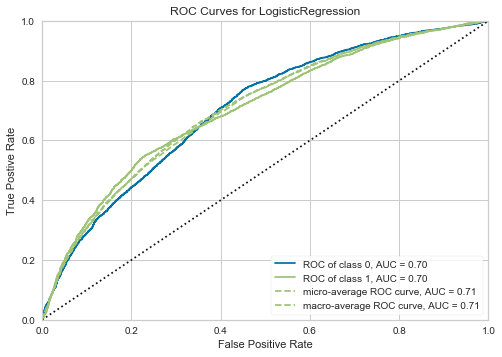

In [201]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import train_test_split

# Extract the numpy arrays from the data frame
X = df_inci_X_scaled.as_matrix()
y = inci_Y.as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Instantiate the classification model and visualizer
logistic = LogisticRegression()
visualizer = ROCAUC(logistic)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()     

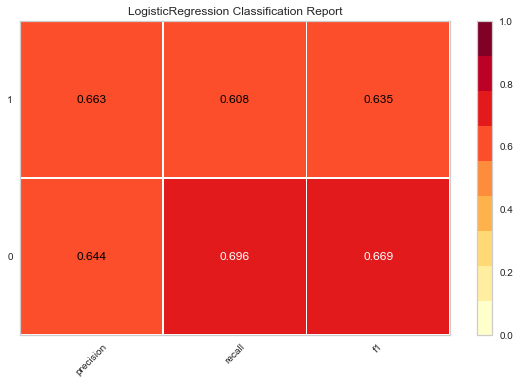

In [202]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
viz = ClassificationReport(LogisticRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

### TASK 2
- Response Time Category Status Classification

In [203]:
incident_resp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72156 entries, 81757 to 255153
Data columns (total 23 columns):
Watch                            72156 non-null int64
Division                         72156 non-null int8
Day1_of_the_Week                 72156 non-null int8
Victim_Type                      72156 non-null int8
Victim_Race                      72156 non-null int8
Victim_Age                       72156 non-null int32
Hate_Crime                       72156 non-null int64
Gang_Related_Offense             72156 non-null int64
Drug_Related                     72156 non-null int64
UCR_Offense_Name                 72156 non-null int8
X_Coordinate                     72156 non-null float64
Y_Coordinate                     72156 non-null float64
UCR_Offense_Description          72156 non-null int8
Number_of_offense                72156 non-null int32
Response_time                    72156 non-null int32
Arrest_status                    72156 non-null int64
Call_Received_Hour      

In [234]:
# Y Response variable dataframe
inci_res_Y = incident_resp['Res_time_category']
# Features with no predictive features with respect to resposne variable
inci_res_X = incident_resp.drop(['Res_time_category', 'Response_time','Arrest_status','Drug_Related', 'Watch'],axis=1) 

from sklearn.preprocessing import StandardScaler
#Scale data
scaler = StandardScaler()
inci_res_X_scaled = scaler.fit_transform(inci_res_X)
#Save as data frames
df_inci_res_X_scaled = pd.DataFrame(inci_res_X_scaled)

### TASK 2.1
- KNN

In [112]:
#KNN Classification 10-fold cross-validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
import warnings
warnings.filterwarnings('ignore')

# # Y Response variable dataframe
# y = incident['Res_time_category'].as_matrix().astype(np.float)
# # Features with no predictive features with respect to resposne variable
# X = incident.drop(['Res_time_category', 'Response_time'],axis=1).as_matrix().astype(np.float)

# #yhat = np.zeros(y.shape) # we will fill this with predictions

# # Scaling training variables
# scl = StandardScaler()
# X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

ClsEstimator = KNeighborsClassifier()

parameters = { 'n_neighbors':[3, 5, 13]
              ,'weights': ['uniform','distance']
              ,'leaf_size': [10, 30]
              ,'metric': ['minkowski','euclidean']
             }
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
ClsGridSearch = GridSearchCV(estimator=ClsEstimator
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
ClsGridSearch.fit(df_inci_res_X_scaled, inci_res_Y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 24.9min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 145.4min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 188.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=10,
       param_grid={'n_neighbors': [3, 5, 13], 'weights': ['uniform', 'distance'], 'leaf_size': [10, 30], 'metric': ['minkowski', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [113]:
#Use the best parameters for our KNN classifier
ClsGridSearchEst = ClsGridSearch.best_estimator_
print(ClsGridSearchEst)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='distance')


In [235]:
yhat = np.zeros(y.shape) # initializing variable

X=inci_res_X.as_matrix().astype(np.float)
y=inci_res_Y.as_matrix().astype(np.float)
for train, test in cv.split(X,y):
    # Use Results parameters from GridSearch to run KNN Classifier model
    clf_knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                   metric_params=None, n_jobs=1, n_neighbors=13, p=2,weights='distance')
    clf_knn.fit(X[train],y[train])
    yhat[test] = clf_knn.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
total_precision = precision_score(y, yhat,average='weighted')
classification_rpt = classification_report(y, yhat)
print ("KNN accuracy with corresponding parameter settings")
print('KNN classifier accuracy with optimal parameters is: %.3f'%(total_accuracy))
print('KNN classifier accuracy with optimal parameters is: %.3f'%(total_precision))
print('KNN classifier classsification report with optimal parameters is: \n',(classification_rpt))

KNN accuracy with corresponding parameter settings
KNN classifier accuracy with optimal parameters is: 0.339
KNN classifier accuracy with optimal parameters is: 0.340
KNN classifier classsification report with optimal parameters is: 
              precision    recall  f1-score   support

        0.0       0.33      0.40      0.36     18039
        1.0       0.32      0.28      0.30     18039
        2.0       0.32      0.30      0.31     18039
        3.0       0.40      0.38      0.39     18039

avg / total       0.34      0.34      0.34     72156



Normalized confusion matrix


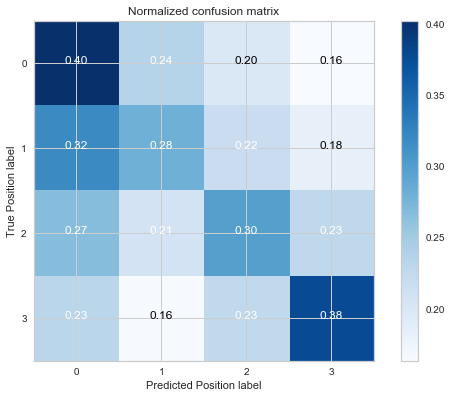

In [236]:

from sklearn.metrics import confusion_matrix
import itertools
class_names = inci_res_Y.unique()

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Position label')
    plt.xlabel('Predicted Position label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### TASK 2.2
- Random forest classifier

In [237]:
# Random Forest
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

# Y Response variable dataframe
y = inci_res_Y
# Features with no predictive features with respect to resposne variable
X = inci_res_X


def runModelCV(cv, clf, varImp = True):
    imps = list()
    accList = list()
    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]  
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accList.append(acc)
        print("Model", i, "Accuracy:", acc)
        imps.append(clf.feature_importances_)
        i += 1
    
    print("Mean Accuracy Across Models: ",np.mean(np.asarray(accList)))
    
    if(varImp):
        fig, ax = plt.subplots(figsize=(15,10))
        im = ax.imshow(imps)
        ax.set_xticks(np.arange(X.shape[1]))
        ax.set_yticks(np.arange(i - 1))
        ax.set_xticklabels(list(X))
        ax.set_yticklabels(np.arange(i) + 1)
        ax.set_xlabel("Feature")
        ax.set_ylabel("Model")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        ax.set_title("Comparison of Variable Importance Across CV Runs")
        fig.tight_layout()
        plt.show()

MODEL TYPE: RandomForestClassifier with StratifiedShuffleSplit 
Model 1 Accuracy: 0.3516491130820399
Model 2 Accuracy: 0.35060975609756095
Model 3 Accuracy: 0.3458980044345898
Model 4 Accuracy: 0.3553215077605322
Model 5 Accuracy: 0.3521341463414634
Mean Accuracy Across Models:  0.3511225055432372


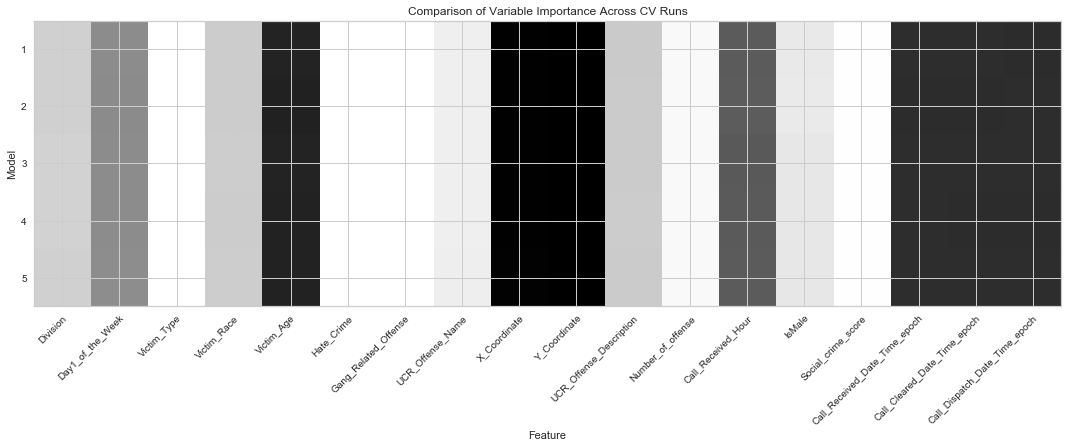

****************************************************************************************
MODEL TYPE: RandomForestClassifier with StratifiedKFold 
Model 1 Accuracy: 0.35109478935698446
Model 2 Accuracy: 0.3407012195121951
Model 3 Accuracy: 0.3508869179600887
Model 4 Accuracy: 0.3401468957871397
Model 5 Accuracy: 0.3294981979484336
Mean Accuracy Across Models:  0.34246560411296834


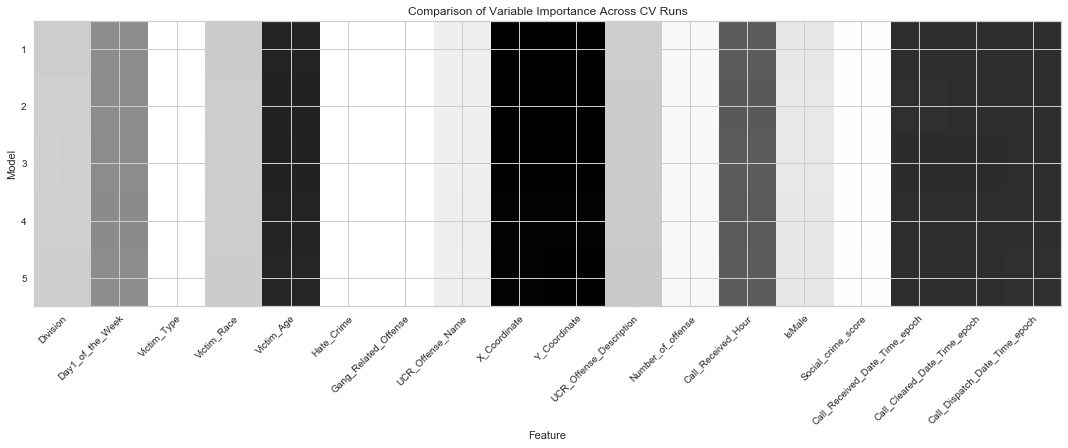

In [238]:
print("MODEL TYPE: RandomForestClassifier with StratifiedShuffleSplit ")
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, train_size=0.8, random_state=0),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))
print('****************************************************************************************')
print("MODEL TYPE: RandomForestClassifier with StratifiedKFold ")
runModelCV(StratifiedKFold(n_splits=5),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

MODEL TYPE: ExtraTreesClassifier with StratifiedShuffleSplit 
Model 1 Accuracy: 0.3351579822616408
Model 2 Accuracy: 0.3348115299334812
Model 3 Accuracy: 0.33106984478935697
Model 4 Accuracy: 0.33862250554323725
Model 5 Accuracy: 0.3353658536585366
Mean Accuracy Across Models:  0.33500554323725057


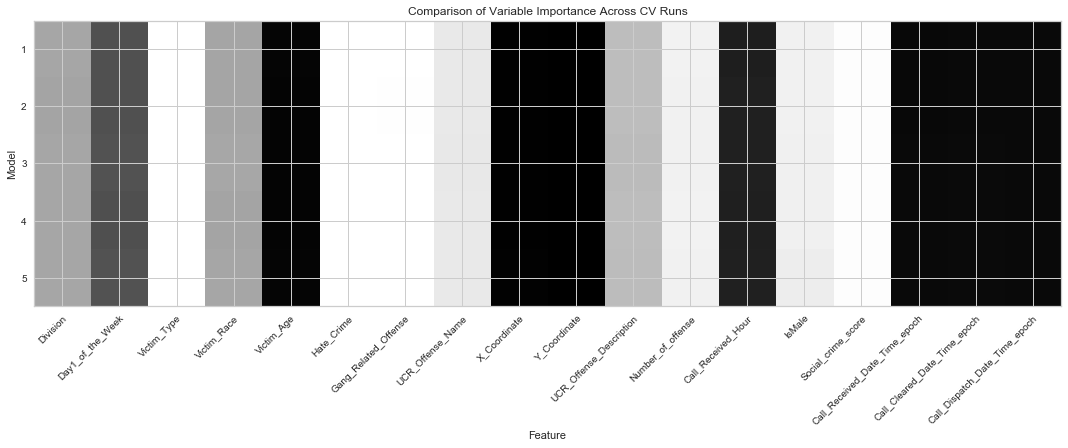

****************************************************************************************
MODEL TYPE: ExtraTreesClassifier with StratifiedKFold 
Model 1 Accuracy: 0.34167128603104213
Model 2 Accuracy: 0.32746674057649666
Model 3 Accuracy: 0.3356430155210643
Model 4 Accuracy: 0.3298919068736142
Model 5 Accuracy: 0.3222206820072082
Mean Accuracy Across Models:  0.33137872620188513


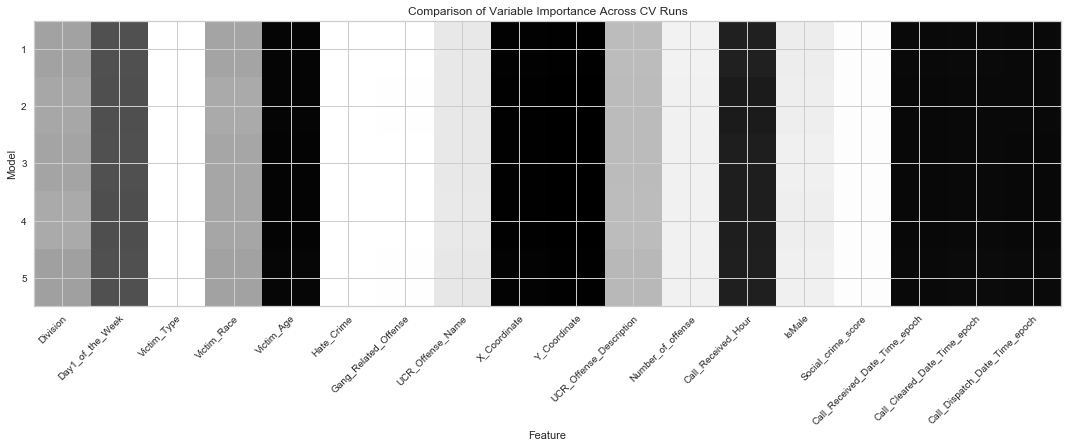

In [239]:
print("MODEL TYPE: ExtraTreesClassifier with StratifiedShuffleSplit ")
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, train_size=0.8, random_state=0),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))
print('****************************************************************************************')
print("MODEL TYPE: ExtraTreesClassifier with StratifiedKFold ")
runModelCV(StratifiedKFold(n_splits=5),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

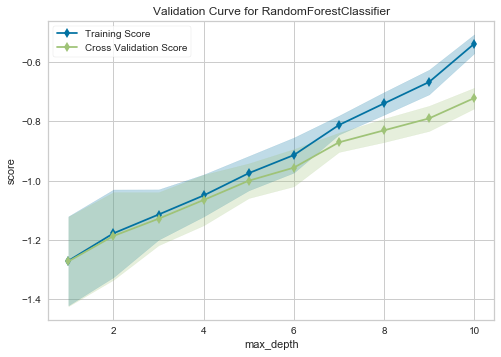

In [240]:
# Validation Curv
from yellowbrick.model_selection import ValidationCurve
from sklearn.ensemble import RandomForestClassifier

param_range = np.arange(1, 11)

oz = ValidationCurve(
    RandomForestClassifier(), param_name="max_depth",
    param_range=param_range, cv=cv, scoring="r2", n_jobs=4,
)

oz.fit(inci_res_X,inci_res_Y)
oz.poof()

### Task 2.3
##### NearestCentroid

In [250]:
%%time
%%time
from sklearn.model_selection import ShuffleSplit

# Create Cross Validation object with 10 fold and 80/20 train-test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)


X = inci_res_X.as_matrix().astype(np.float)
y = inci_res_Y.as_matrix().astype(np.float)



from sklearn.neighbors.nearest_centroid import NearestCentroid
for d in ['l1', 'l2', 'cosine', 'euclidean']:
    imps = list()
    accList = list()
    i=1
    for trainidx, testidx in cv.split(inci_X,inci_Y):
        X_train, X_test = X[trainidx], X[testidx]    
        y_train, y_test = y[trainidx], y[testidx]
        clf = NearestCentroid(metric=d)
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)
        acc = accuracy_score(y_test, yhat)
        pres = precision_score(y_test, yhat, average='weighted')
        accList.append(acc)
        print("Model", i , "|| Accuracy:", acc, "|| Precision: ", pres)
        i=i+1
#         print("Model", i, "Precision:", pres)
    
    print("\n Mean Accuracy Across Models of : ",d, "is",np.mean(np.asarray(accList)), "\n")



Model 1 || Accuracy: 0.26633369330453566 || Precision:  0.513591267122975
Model 2 || Accuracy: 0.26120410367170627 || Precision:  0.4975958917044446
Model 3 || Accuracy: 0.47516198704103674 || Precision:  0.4779805131861408
Model 4 || Accuracy: 0.24325053995680346 || Precision:  0.4731253201566053
Model 5 || Accuracy: 0.25 || Precision:  0.47607766475403446
Model 6 || Accuracy: 0.23839092872570194 || Precision:  0.4637863907399462
Model 7 || Accuracy: 0.25337473002159827 || Precision:  0.4731205182339203
Model 8 || Accuracy: 0.453158747300216 || Precision:  0.46254057791311387
Model 9 || Accuracy: 0.2517548596112311 || Precision:  0.48096936622061587
Model 10 || Accuracy: 0.24986501079913606 || Precision:  0.4730518563289245

 Mean Accuracy Across Models of :  l1 is 0.2942494600431965 

Model 1 || Accuracy: 0.26646868250539957 || Precision:  0.5153905423399449
Model 2 || Accuracy: 0.2601241900647948 || Precision:  0.4991735150119112
Model 3 || Accuracy: 0.46746760259179265 || Precision

# Modeling and Evaluation 4

- Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.



In [242]:
## Credit To: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

# ***********MODELS FUNCTION*************
# evaluate each model in turn
def Results_analysis(fmodels, fscoring, fX, fy):
    results = []
    names = []
    #scoring = 'accuracy'
    for name, model in fmodels:
        if (fscoring == 'accuracy'):
            skf = StratifiedKFold(n_splits=10, random_state=seed)
        else:
            skf = 10
        cv_results = model_selection.cross_val_score(model, fX, fy, cv=skf, scoring=fscoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    sns.boxplot(x=names, y=results, palette="Set1")
    plt.show()
    
    return [names, results]

### Arrest Status (models in TASK 1)
- Mean Accuracy of models
- Std of models

KNN: 0.570032 (0.019415)
RF: 0.736312 (0.025485)
RFET: 0.734989 (0.025025)
Logit_RFECV: 0.499838 (0.000324)


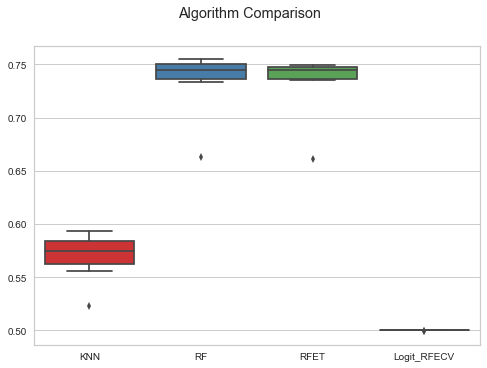

In [251]:
## Credit To: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

seed = 7
# prepare models
class_models = []
class_models.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                                 metric_params=None, n_jobs=1, n_neighbors=13, p=2,weights='distance')))

class_models.append(('RF', RandomForestClassifier(n_estimators=600, max_depth=None, min_samples_split=2, 
                                                  random_state=0,  n_jobs=-1)))

class_models.append(('RFET', ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, 
                                                  random_state=0,  n_jobs=-1)))


class_models.append(('Logit_RFECV', LogisticRegression()))


classModelResults = Results_analysis(class_models, 'accuracy', inci_X, inci_Y)

### Response Time Category (models in TASK 2)
- Mean Accuracy of models
- Std of models

KNN: 0.350697 (0.010865)
RF: 0.350253 (0.012261)
RFET: 0.333983 (0.010034)
NearestCentroid: 0.245799 (0.010088)


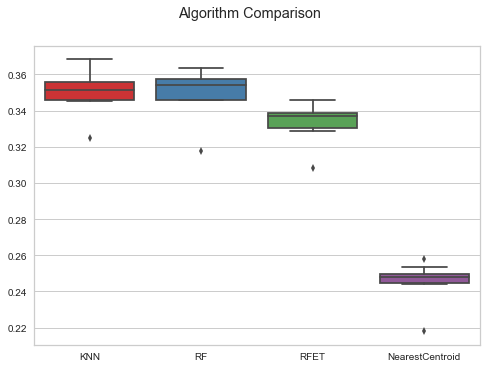

In [252]:
## Credit To: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

seed = 7
# prepare models
class_models_R = []

class_models_R.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                                                   metric_params=None, n_jobs=1, n_neighbors=13, p=2,weights='distance')))

class_models_R.append(('RF', RandomForestClassifier(n_estimators=600, max_depth=None, min_samples_split=2, 
                                                    random_state=0,  n_jobs=-1)))

class_models_R.append(('RFET', ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, 
                                                    random_state=0,  n_jobs=-1)))

class_models_R.append(('NearestCentroid', NearestCentroid(metric='l1')))


classModelResults_R = Results_analysis(class_models_R, 'accuracy', inci_res_X, inci_res_Y)

# Modeling and Evaluation 5 

- Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.



In [253]:
# credit: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# credit: https://stackoverflow.com/questions/5389507/iterating-over-every-two-elements-in-a-list
from math import sqrt
from scipy import stats
# Iterate Pairwise through models and calculate CI
def modelCiComp(modelResults):
    for i in range(len(classModelResults[0])):
        for j in range(i+1, len(classModelResults[1])):
            m1Acc = classModelResults[1][i]
            m2Acc = classModelResults[1][j]
            d = m1Acc - m2Acc
            dBar = np.mean(d)
            v = np.var(d)
            ci = (1/sqrt(len(m1Acc)))*stats.t.ppf(q = .975, df = len(m1Acc) - 1)*sqrt(v)
            ci = "[" + str(round(dBar - ci, 5)) + ", " + str(round(dBar + ci, 5)) + "]"
            print("95% CI for", classModelResults[0][i], "vs", classModelResults[0][j], "=", ci)

#### Arrest Status models

In [254]:
modelCiComp(classModelResults)

95% CI for KNN vs RF = [-0.17575, -0.15681]
95% CI for KNN vs RFET = [-0.17535, -0.15456]
95% CI for KNN vs Logit_RFECV = [0.05633, 0.08406]
95% CI for RF vs RFET = [-0.00101, 0.00366]
95% CI for RF vs Logit_RFECV = [0.2182, 0.25474]
95% CI for RFET vs Logit_RFECV = [0.2172, 0.2531]


#### Response time category models

In [255]:
modelCiComp(classModelResults_R)

95% CI for KNN vs RF = [-0.17575, -0.15681]
95% CI for KNN vs RFET = [-0.17535, -0.15456]
95% CI for KNN vs Logit_RFECV = [0.05633, 0.08406]
95% CI for RF vs RFET = [-0.00101, 0.00366]
95% CI for RF vs Logit_RFECV = [0.2182, 0.25474]
95% CI for RFET vs Logit_RFECV = [0.2172, 0.2531]


# Modeling and Evaluation 6 

- Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


#### Arrest status

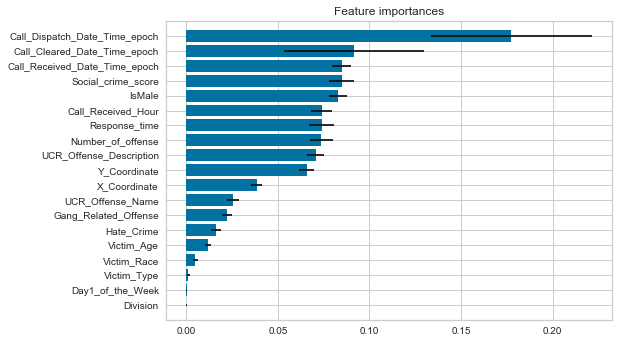

In [269]:
# model = RandomForestClassifier()

# forest = ExtraTreesClassifier(n_estimators=250,
#                               random_state=0)
forest =RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

forest.fit(inci_X, inci_Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(inci_X.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(inci_X.shape[1]), inci_X.columns)
plt.ylim([-1, inci_X.shape[1]])
plt.show()

### Response time cat

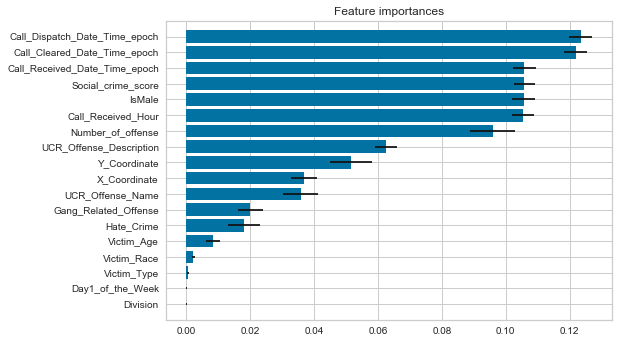

In [270]:
# model = RandomForestClassifier()

# forest = ExtraTreesClassifier(n_estimators=250,
#                               random_state=0)
forest =RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

forest.fit(inci_res_X, inci_res_Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(inci_res_X.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(inci_res_X.shape[1]), inci_res_X.columns)
plt.ylim([-1, inci_res_X.shape[1]])
plt.show()

# Deployment

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 



# Exceptional Work 

- You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

###### END OF REPORT

# TESTING CODE 

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


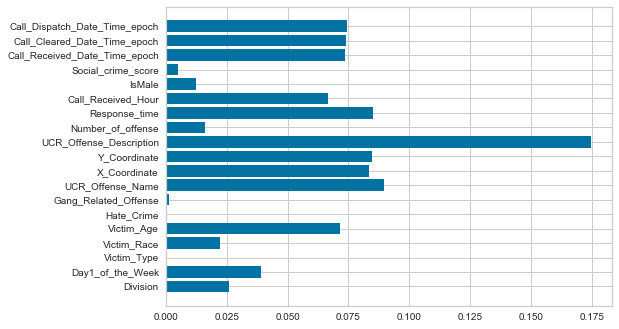

Generalization score estimate from training data 0.7385799136069114


In [274]:
# KNN: 0.705720 (0.012338)

# now lets get access to the different properties of our RF
clf = RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

clf.fit(inci_X,inci_Y)
    
print (clf)

plt.barh(inci_X.columns, clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)


# oob_SCORE - Very close to accuracy, represents data which are not just a guess and are not placed on the main data for ..
# ..do not use it as a replacement to cross validation

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


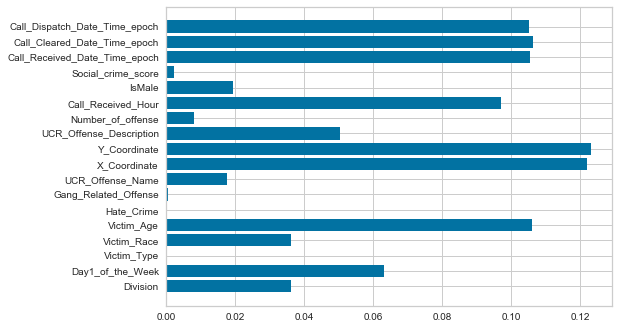

Generalization score estimate from training data 0.3512251233438661


In [275]:
# KNN: 0.705720 (0.012338)

# now lets get access to the different properties of our RF
clf = RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1, oob_score=True, class_weight="balanced")

clf.fit(inci_res_X,inci_res_Y)
    
print (clf)

plt.barh(inci_res_X.columns, clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)


# oob_SCORE - Very close to accuracy, represents data which are not just a guess and are not placed on the main data for ..
# ..do not use it as a replacement to cross validation